In [602]:
import pandas as pd
import numpy as np
from my_pysyncon import Dataprep, Synth, AugSynth
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import empirical_covariance

In [603]:
# import the data

df_mo = pd.read_csv('../../../SharedData/total_state_data.csv')
df_yr = pd.read_csv('../../../SharedData/yearly_total_data.csv')

In [604]:
# this list is used to make certain columns later

abbreviations = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

# DC isn't a state (sorry not sorry)

df_mo = df_mo[df_mo.state != 'DC']
df_yr = df_yr[df_yr.state != 'DC']

In [605]:
# add a bunch of features (these will eventually get moved to combine_files.ipynb)

df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['monthly_population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['monthly_population']
df_mo['eprod_per_capita'] = df_mo['monthly_energy_prod'] / df_mo['monthly_population']
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']
#df_mo['num_plants_per_capita'] = df_mo['monthly_num_plants'] / df_mo['monthly_population']

# create column for simple moving avg of co2_per_capita; ma_window is the moving average window size (n=1 corresponds to usual monthly results)

df_mo['co2_per_capita_sma']= np.nan
ma_window = 6

for state in abbreviations:
    df_mo.loc[df_mo.state==state,'co2_per_capita_sma'] = df_mo.loc[df_mo.state==state,'co2_per_capita'].rolling(window=ma_window).mean()


df_yr['co2_per_capita'] = df_yr['yearly_emissions'] / df_yr['yearly_population']
df_yr['gdp_per_capita'] = df_yr['yearly_gdp_rel_2017'] / df_yr['yearly_population']
df_yr['eprod_per_capita'] = df_yr['yearly_energy_prod'] / df_yr['yearly_population']
df_yr['eflow_per_capita'] = df_yr['yearly_energy_flow'] / df_yr['yearly_population']
#df_yr['num_plants_per_capita'] = df_yr['yearly_num_plants'] / df_yr['yearly_population']

In [606]:
# set number of months to skip at a time when training monthly model.
# month_jumps = 1 means consider all monthly data; month_jumps = 12 means consider one month per year
month_jumps = 1

treatment_date = '2009-01-01'
preintervention_ma_start_date = str((pd.to_datetime('1990-06-01')+ pd.DateOffset(months=ma_window-1)).strftime('%Y-%m-%d'))

# these are the time values where CO2 per capita is fit
preintervention_time_range = df_mo.date[(df_mo.date >= '1990-06-01')&(df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]

# these are dates that Jared is testing to see if other time subsets give better fits


# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df_mo.date[(df_mo.date >= '1997-01-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]
preintervention_weather_range = df_mo.date[(df_mo.date >= '1990-01-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]
preintervention_gdp_range = df_mo.date[(df_mo.date >= '1997-12-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]
preintervention_per_capita_range = df_mo.date[(df_mo.date >= '1990-06-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]
preintervention_energy_range = df_mo.date[(df_mo.date >= '1990-12-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]
preintervention_ma_range = df_mo.date[(df_mo.date >= preintervention_ma_start_date) & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]


# these are the dates used for our monthly_emissions graph
years = pd.date_range(start='1990-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]

# these are the dates used for our monthly_emissions SMA graph
years_sma = pd.date_range(start=preintervention_ma_start_date, end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]

## PCA Calculation

In [607]:
# separate df_mo into two pieces
non_pca_cols = df_mo[(df_mo.date >= '1990-11')&(df_mo.date <='2019-12-01')][['state','date','co2_per_capita_sma','gdp_per_capita','monthly_num_plants']]
num_cols = df_mo[(df_mo.date>=preintervention_ma_start_date) & (df_mo.date<=treatment_date)].drop(columns=['state','date','co2_per_capita_sma'])
# drop outcomes for PCA; 
# drop weather data because too many missing values
# drop GDP and num_plants because only have data for 1997-
# drop yearly data because this is PCA for monthly model
# drop non-per-capita versions of per-capita data to reduce redundancy
# drop non-density versions of data to reduce redundancy
df_mo_pca = num_cols[[
       'yearly_renew_pct', 'yearly_fossil_pct','monthly_pop_density','eprod_per_capita','eflow_per_capita']]
print('number of features before PCA calculation is',len(df_mo_pca.columns))

# save the indices to be used later in pca_df
df_mo_pca_indices = df_mo_pca.index

# make covariance matrix to see how features are correlated
empirical_covariance(df_mo_pca)

number of features before PCA calculation is 5


array([[ 0.04362116, -0.03544089,  0.00230327, -0.00306964, -0.00257274],
       [-0.03544089,  0.06491524,  0.00082472,  0.01071661,  0.00966068],
       [ 0.00230327,  0.00082472,  0.00161957,  0.00458781,  0.00437969],
       [-0.00306964,  0.01071661,  0.00458781,  0.0316035 ,  0.0303851 ],
       [-0.00257274,  0.00966068,  0.00437969,  0.0303851 ,  0.02930006]])

In [608]:
# We'll use PCA to make the covariates independent (which I think is an underlying assumption of a diagonal V)
# Standardize the covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_mo_pca)

# Apply PCA
n_components = 5
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


# Add the state and date back
pca_col_names = ['PCA'+str(i) for i in range(1,n_components+1)]
pca_df = pd.DataFrame(X_pca, columns=pca_col_names)
cov_mat = empirical_covariance(pca_df)
cov_mat[np.abs(cov_mat)<10**(-5)]=0
np.set_printoptions(suppress=True)
print('Percent of total variance from each component:', np.diag(cov_mat)/np.trace(cov_mat)*100)

Percent of total variance from each component: [52.03327423 33.76705326  9.88232153  4.29127063  0.02608035]


This suggests that we only need 4 components (since the 5th component composes 0.026% of total variance). So let's redo the PCA with n_components = 4.

In [609]:
# We'll use PCA to make the covariates independent (which I think is an underlying assumption of a diagonal V)
# Standardize the covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_mo_pca)

# Apply PCA
n_components = 4
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Add the state and date back
pca_col_names = ['PCA'+str(i) for i in range(1,n_components+1)]
pca_df = pd.DataFrame(X_pca, columns=pca_col_names)
pca_df.index = df_mo_pca_indices
cov_mat = empirical_covariance(pca_df)
cov_mat[np.abs(cov_mat)<10**(-5)]=0
np.set_printoptions(suppress=True)
print('Percent of total variance from each component:', np.diag(cov_mat)/np.trace(cov_mat)*100)


merged_pca_df = pca_df.merge(non_pca_cols, left_index=True, right_index=True, how='right')

Percent of total variance from each component: [52.04684823 33.77586213  9.88489955  4.2923901 ]


We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [610]:
# we leave off RGGI states, states with no CO2 data (AK, HI), as well as states with some type of emissions program (CA, WA)

rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']

non_rggi_controls_identifier= [
    "AL", 
    #"AK", 
    "AZ", "AR", 
    #"CA", 
    "CO", 
    #"CT", 
    #"DE", 
    "FL", 
    "GA",
    #"HI", 
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", 
    #"ME", 
    #"MD",
    #"MA", 
    "MI", "MN", "MS", "MO", "MT", "NE", "NV", 
    #"NH", 
    #"NJ",
    "NM", "NC", "ND", "OH", "OK", 
    "OR", 
    "PA", 
    #"RI", 
    "SC", "SD", "TN", 
    "TX", 
    "UT", 
    #"VT", 
    #"VA", 
    #"WA", 
    "WV", "WI", "WY"
    ]

In [611]:
# we create a synthetic control Delaware as applied to monthly_emissions data

dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['monthly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

In [612]:
# we create a synthetic control Delaware as applied to monthly_emissions SMA data

dataprep_mo_ma = Dataprep(
    foo=df_mo,
    predictors=['monthly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )

In [613]:
# we create a synthetic control Delaware as applied to monthly_emissions SMA PCA data

dataprep_mo_ma_pca = Dataprep(
    foo=merged_pca_df,
    predictors=pca_col_names+['monthly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('gdp_per_capita', preintervention_gdp_range, "mean")
        ],
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )

In [614]:
# we create a synthetic control Delaware as applied to yearly data

dataprep_yr = Dataprep(
    foo=df_yr,
    predictors=['yearly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=range(1997,2009),#range(1997,2009),
    special_predictors=[
        ('eprod_per_capita', range(1990,2009), "mean"),
        ('eflow_per_capita', range(1990,2009), "mean"),
        ('gdp_per_capita', range(1997,2009), "mean"),
        ('yearly_pop_density', range(1990,2009), "mean"),
        ('yearly_renew_pct', range(1990,2009), "mean"),
        ('yearly_fossil_pct', range(1990,2009), "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="year",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=range(1990,2009)
)

print(dataprep_yr)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: AL, AZ, AR, CO, FL, GA, ID, IL, IN, IA, KS, KY, LA, MI, MN, MS, MO, MT, NE, NV, NM, NC, ND, OH, OK, OR, PA, SC, SD, TN, TX, UT, WV, WI, WY
Time range in data: 1990 - 2024
Time range for loss minimization: range(1990, 2009)
Time range for predictors: range(1997, 2009)
Predictors: yearly_num_plants
Special predictors:
    `eprod_per_capita` over `range(1990, 2009)` using `mean`
    `eflow_per_capita` over `range(1990, 2009)` using `mean`
    `gdp_per_capita` over `range(1997, 2009)` using `mean`
    `yearly_pop_density` over `range(1990, 2009)` using `mean`
    `yearly_renew_pct` over `range(1990, 2009)` using `mean`
    `yearly_fossil_pct` over `range(1990, 2009)` using `mean`




We supply the `Dataprep` object to a `Synth` object. The optimization scheme we could use is [BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) and the starting point we could use for the optimisation is `ols` i.e. the initial weights are obtained by fitting an ordinary-least-squares estimate. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point.*

In [615]:
# monthly_emissions version
# loss_V represents the MSPE (mean squared prediction error) PRIOR to treatment
# loss_V incorporates matrix of weights W and CO2 outcomes
# loss_W incorporates covariates (predictors) and constraint of weights summing to 1
# best values of loss_W are close to 0 (but loss_V is more consequential for us!)

synth_mo = Synth()
synth_mo.fit(dataprep=dataprep_mo)
print(synth_mo.weights(threshold=.01))
print(synth_mo.loss_V)
#print(synth_mo.loss_W)

IL    0.118
MN    0.421
NV    0.461
Name: weights, dtype: float64
0.03464696408547287


In [616]:
# monthly_emissions SMA version

synth_mo_ma = Synth()
synth_mo_ma.fit(dataprep=dataprep_mo_ma)
print(synth_mo_ma.weights(threshold=.01))
print(synth_mo_ma.loss_V)
#print(synth_mo_ma.loss_W)

# how different is co2_per_capita_sma different than co2_per_capita?
sma_mse = mean_squared_error(df_mo[(df_mo.date>=preintervention_ma_start_date) & (df_mo.date<=treatment_date)]['co2_per_capita'], df_mo[(df_mo.date>=preintervention_ma_start_date) & (df_mo.date<=treatment_date)].co2_per_capita_sma)
print('The pre-treatment fit loss is:', synth_mo_ma.loss_V, 'and the rolling average loss is:',sma_mse)


MN    0.557
NV    0.443
Name: weights, dtype: float64
0.015812691995238284
The pre-treatment fit loss is: 0.015812691995238284 and the rolling average loss is: 0.030233796235440747


In [617]:
# monthly_emissions SMA PCA version

synth_mo_ma_pca = Synth()
synth_mo_ma_pca.fit(dataprep=dataprep_mo_ma_pca)
print(synth_mo_ma_pca.weights(threshold=.01))
print(synth_mo_ma_pca.loss_V)
#print(synth_mo_ma.loss_W)

# how different is co2_per_capita_sma different than co2_per_capita?
#sma_mse = mean_squared_error(df_mo[(df_mo.date>=preintervention_ma_start_date) & (df_mo.date<=treatment_date)]['co2_per_capita'], df_mo[(df_mo.date>=preintervention_ma_start_date) & (df_mo.date<=treatment_date)].co2_per_capita_sma)
#print('The pre-treatment fit loss is:', synth_mo_ma.loss_V, 'and the rolling average loss is:',sma_mse)


CO    0.79
NV    0.21
Name: weights, dtype: float64
0.025350906674930524


In [618]:
# yearly version

synth_yr= Synth()
synth_yr.fit(dataprep=dataprep_yr)
print(synth_yr.weights(threshold=.01))
print(synth_yr.loss_V)
#print(synth_mo.loss_W)

MN    0.538
NV    0.462
Name: weights, dtype: float64
1.253858721890658


In [619]:
# these lists are used for treatment_time in graphs below

treatment_dates = []
for year in years:
    if year.startswith('2009'):
        treatment_dates.append(year)

treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

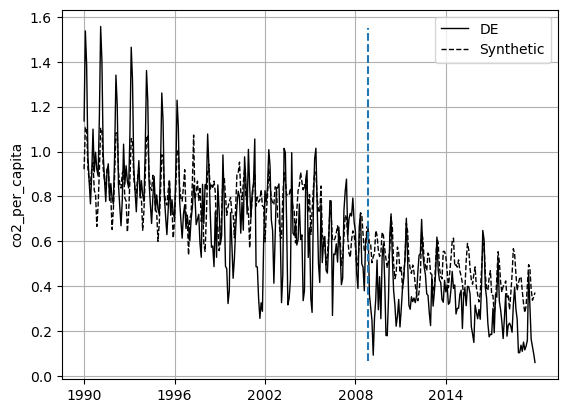

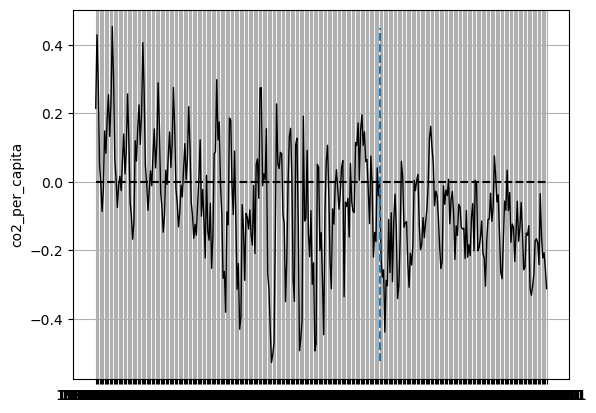

In [620]:
# Monthly_emissions synthetic control plot

synth_mo.path_plot(time_period=years, treatment_time=treatment_dates[0])
synth_mo.gaps_plot(time_period=years, treatment_time=treatment_dates[0])

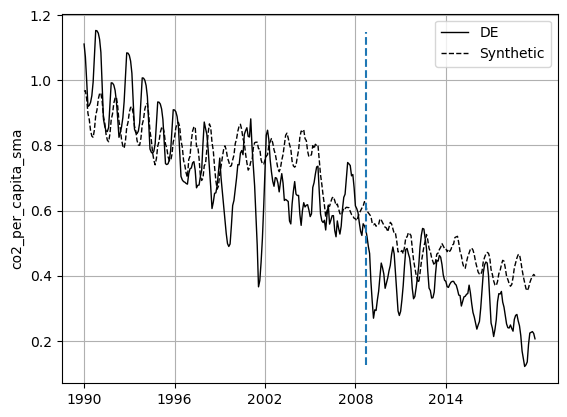

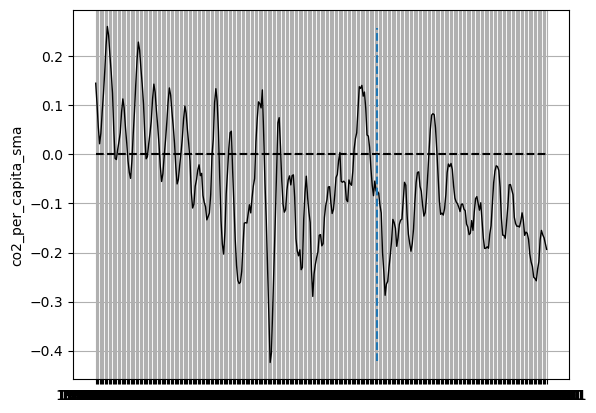

In [621]:
# Monthly_emissions SMA synthetic control plot

synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
synth_mo_ma.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

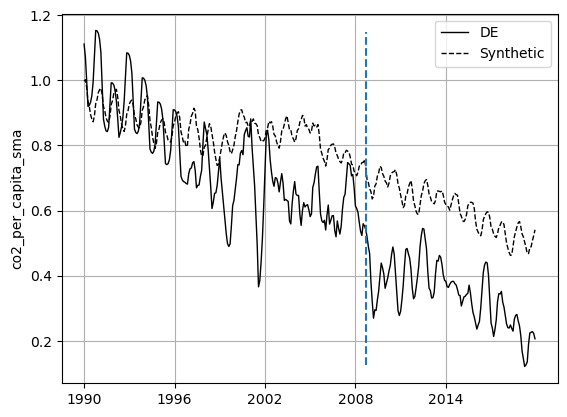

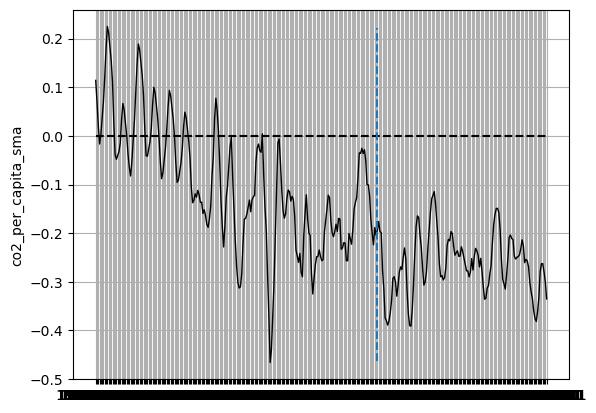

In [622]:
synth_mo_ma_pca.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
synth_mo_ma_pca.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

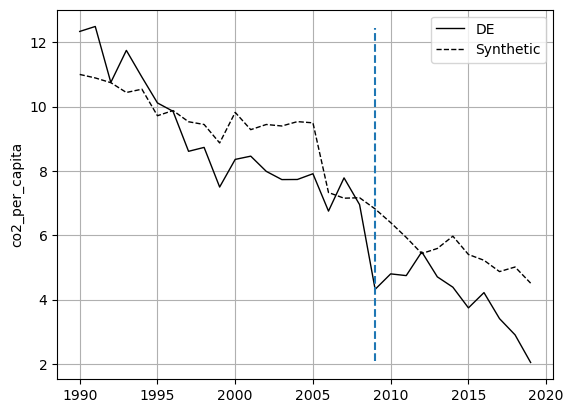

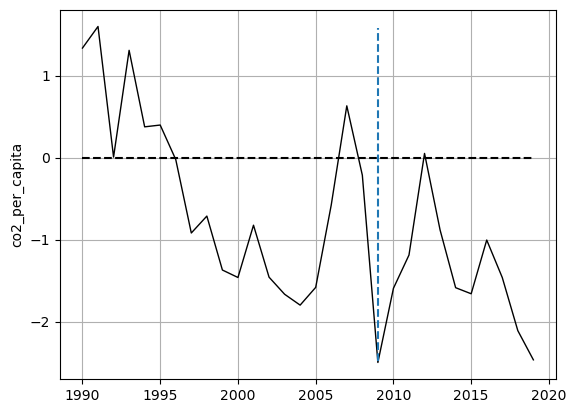

In [623]:
# Yearly synthetic control plot

synth_yr.path_plot_orig(time_period=range(1990,2020), treatment_time=2009)
synth_yr.gaps_plot(time_period=range(1990,2020), treatment_time=2009)

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [624]:
synth_mo.summary()

,V,treated,synthetic,sample mean
monthly_num_plants,0.212,7.840,16.834,21.661
special.1.eprod_per_capita,0.181,0.000,0.004,0.064
special.2.eflow_per_capita,0.157,-0.030,-0.023,0.031
special.3.gdp_per_capita,0.130,0.006,0.005,0.004
special.4.monthly_pop_density,0.186,0.003,0.036,0.034
special.5.yearly_renew_pct,0.133,0.000,0.071,0.105
special.6.yearly_fossil_pct,0.000,0.963,0.750,0.729


In [625]:
synth_mo_ma.summary()

,V,treated,synthetic,sample mean
monthly_num_plants,0.244,7.840,14.267,21.661
special.1.eprod_per_capita,0.063,0.000,0.003,0.064
special.2.eflow_per_capita,0.118,-0.030,-0.024,0.031
special.3.gdp_per_capita,0.129,0.006,0.005,0.004
special.4.monthly_pop_density,0.209,0.003,0.037,0.034
special.5.yearly_renew_pct,0.191,0.000,0.074,0.105
special.6.yearly_fossil_pct,0.045,0.963,0.767,0.729


In [626]:
synth_mo_ma_pca.summary()

,V,treated,synthetic,sample mean
PCA1,0.260,-0.336,0.161,0.255
PCA2,0.157,-1.280,-0.850,-0.153
PCA3,0.121,0.235,0.594,0.142
PCA4,0.221,0.435,0.306,0.028
monthly_num_plants,0.153,7.840,17.295,21.661
special.1.gdp_per_capita,0.089,0.006,0.005,0.004


In [627]:
synth_yr.summary()

,V,treated,synthetic,sample mean
yearly_num_plants,0.170,6.917,13.973,20.790
special.1.eprod_per_capita,0.298,0.002,0.031,0.768
special.2.eflow_per_capita,0.108,-0.359,-0.291,0.375
special.3.gdp_per_capita,0.083,0.078,0.056,0.046
special.4.yearly_pop_density,0.172,0.003,0.038,0.035
special.5.yearly_renew_pct,0.133,0.000,0.075,0.106
special.6.yearly_fossil_pct,0.036,0.964,0.771,0.729


## RGGI State Synthetic Control Comparisons

First, we compare the RGGI synthetic controls at the monthly level.

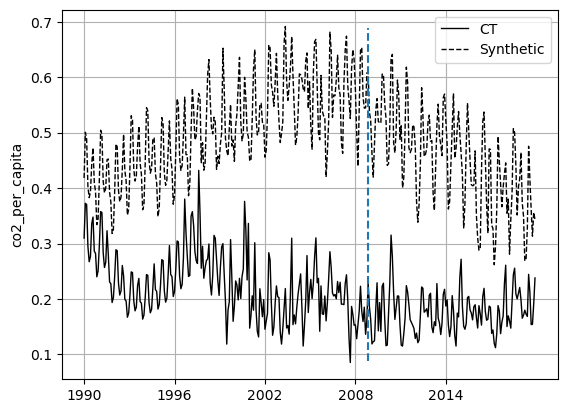

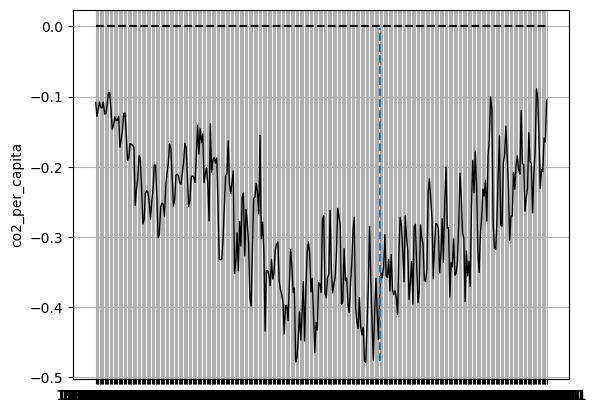

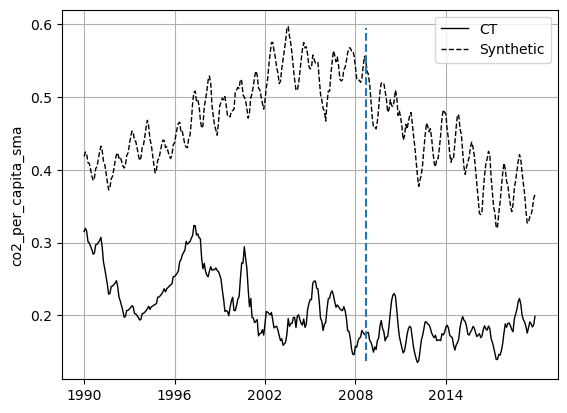

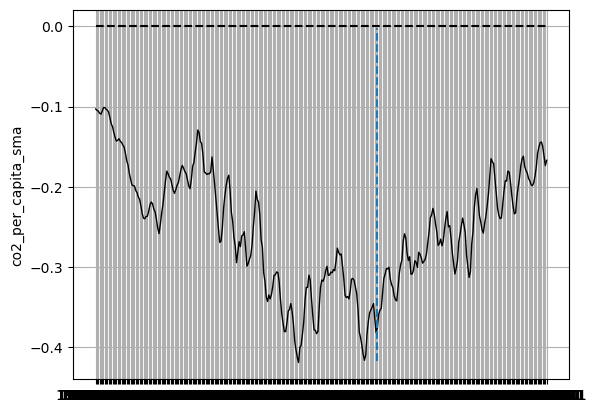

State: CT 

monthly_emissions version: 

IL    0.435
MN    0.326
OR    0.238
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.084   15.229     24.823       21.661
special.1.eprod_per_capita     0.019    0.005      0.008        0.064
special.2.eflow_per_capita     0.529   -0.015     -0.017        0.031
special.3.gdp_per_capita       0.028    0.006      0.004        0.004
special.4.monthly_pop_density  0.077    0.002      0.015        0.034
special.5.yearly_renew_pct     0.000    0.016      0.193        0.105
special.6.yearly_fossil_pct    0.264    0.461      0.492        0.729
monthly_emissions SMA version: 

IL    0.295
MN    0.411
OR    0.294
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.095   15.229     20.833       21.661
special.1.eprod_per_capita     0.229    0.005      0.007        0.064
special.2.eflow_per_

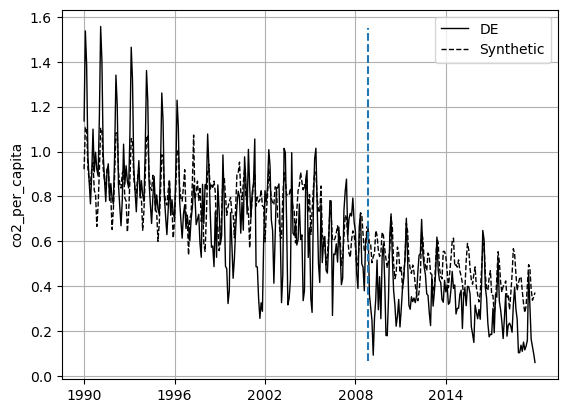

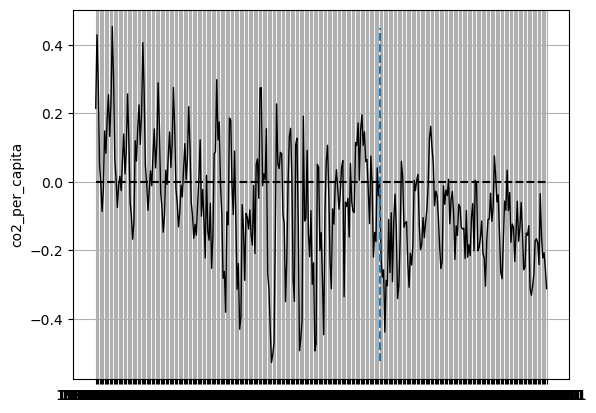

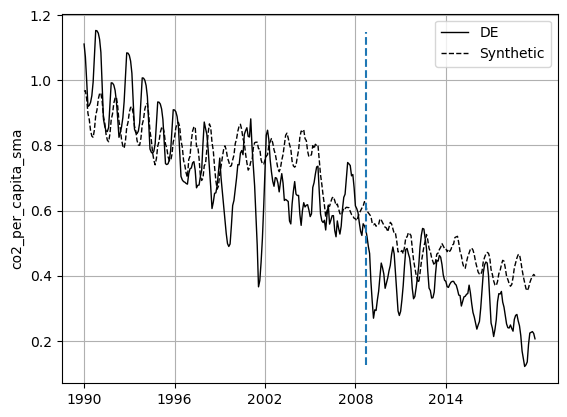

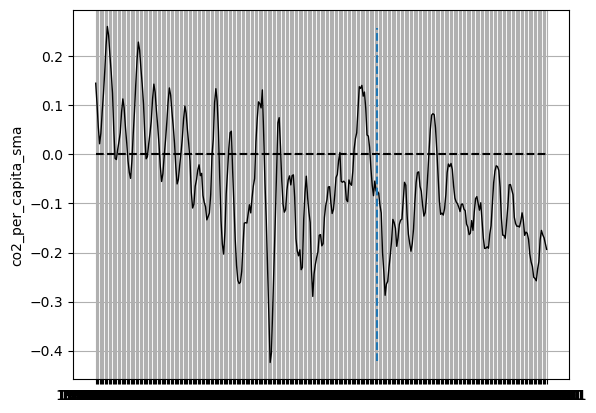

State: DE 

monthly_emissions version: 

IL    0.118
MN    0.421
NV    0.461
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.212    7.840     16.834       21.661
special.1.eprod_per_capita     0.181    0.000      0.004        0.064
special.2.eflow_per_capita     0.157   -0.030     -0.023        0.031
special.3.gdp_per_capita       0.130    0.006      0.005        0.004
special.4.monthly_pop_density  0.186    0.003      0.036        0.034
special.5.yearly_renew_pct     0.133    0.000      0.071        0.105
special.6.yearly_fossil_pct    0.000    0.963      0.750        0.729
monthly_emissions SMA version: 

MN    0.557
NV    0.443
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.244    7.840     14.267       21.661
special.1.eprod_per_capita     0.063    0.000      0.003        0.064
special.2.eflow_per_capita     0

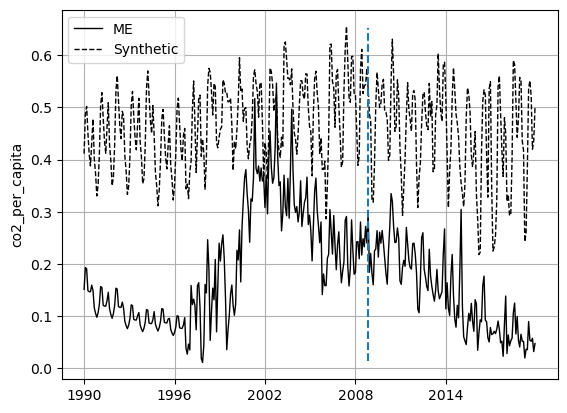

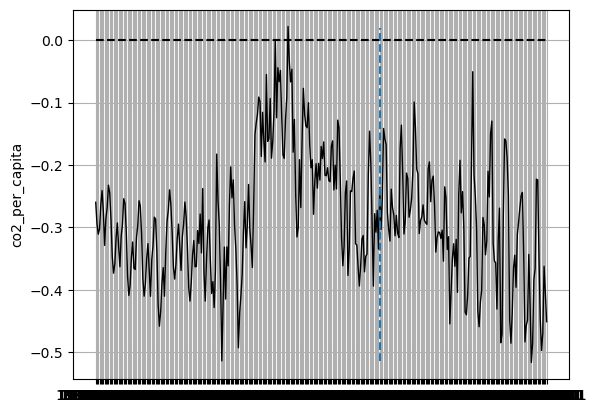

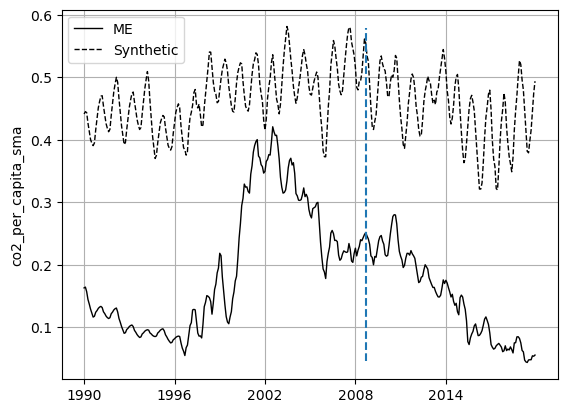

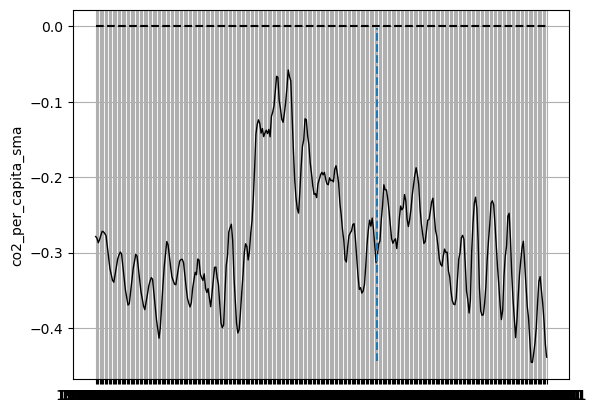

State: ME 

monthly_emissions version: 

AR    0.179
OR    0.669
TN    0.023
UT    0.129
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.156    4.479      6.032       21.661
special.1.eprod_per_capita     0.138    0.010      0.011        0.064
special.2.eflow_per_capita     0.169   -0.018     -0.012        0.031
special.3.gdp_per_capita       0.115    0.004      0.004        0.004
special.4.monthly_pop_density  0.209    0.028      0.028        0.034
special.5.yearly_renew_pct     0.000    0.240      0.524        0.105
special.6.yearly_fossil_pct    0.213    0.396      0.395        0.729
monthly_emissions SMA version: 

AR    0.179
OR    0.669
TN    0.023
UT    0.129
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.156    4.479      6.032       21.661
special.1.eprod_per_capita     0.138    0.010      0.011        0.

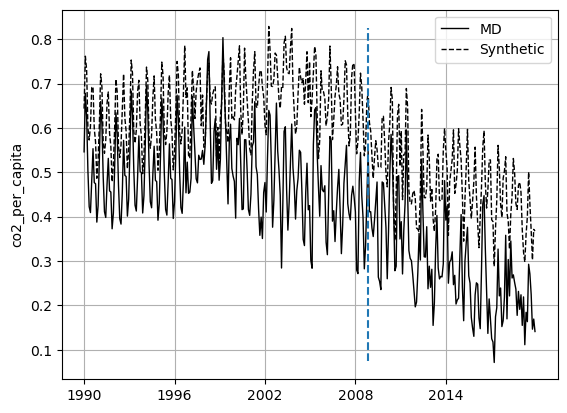

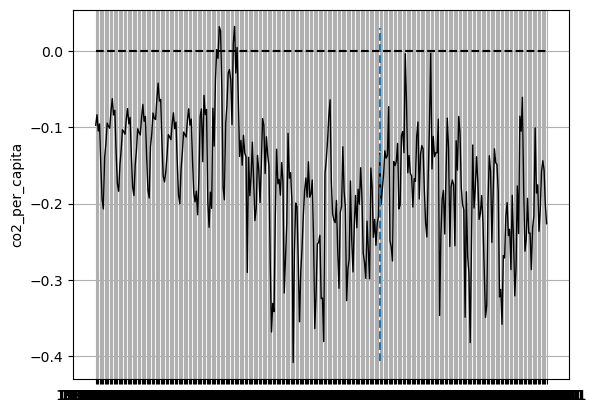

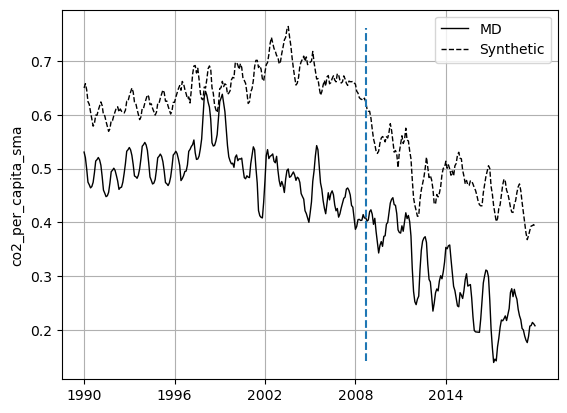

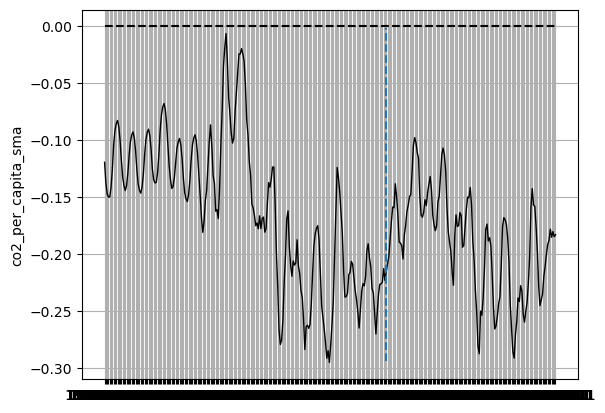

State: MD 

monthly_emissions version: 

MN    0.898
TN    0.093
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.026   13.000     17.308       21.661
special.1.eprod_per_capita     0.124    0.004      0.004        0.064
special.2.eflow_per_capita     0.185   -0.018     -0.025        0.031
special.3.gdp_per_capita       0.254    0.004      0.004        0.004
special.4.monthly_pop_density  0.033    0.002      0.017        0.034
special.5.yearly_renew_pct     0.238    0.038      0.042        0.105
special.6.yearly_fossil_pct    0.139    0.670      0.674        0.729
monthly_emissions SMA version: 

MN    0.897
SC    0.012
TN    0.087
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.025   13.000     17.373       21.661
special.1.eprod_per_capita     0.121    0.004      0.004        0.064
special.2.eflow_per_capita     0

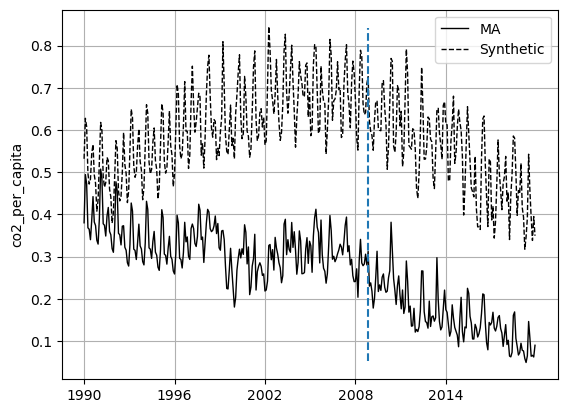

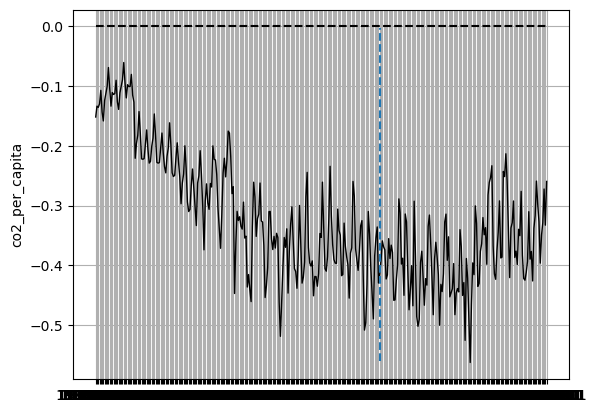

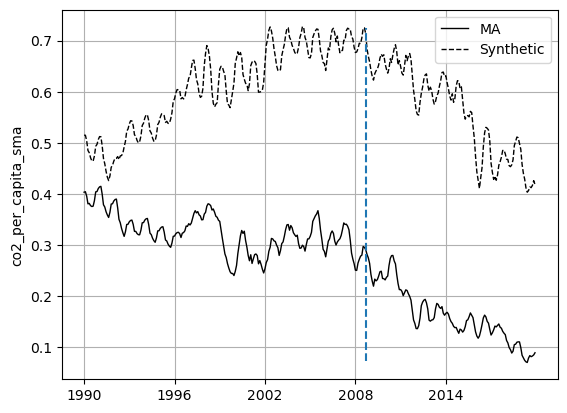

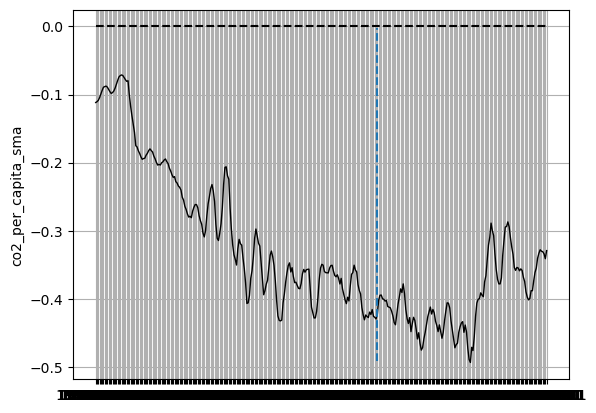

State: MA 

monthly_emissions version: 

IL    0.645
MN    0.355
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.094   26.167     32.868       21.661
special.1.eprod_per_capita     0.179    0.001      0.010        0.064
special.2.eflow_per_capita     0.043   -0.018     -0.017        0.031
special.3.gdp_per_capita       0.115    0.005      0.005        0.004
special.4.monthly_pop_density  0.351    0.002      0.009        0.034
special.5.yearly_renew_pct     0.218    0.024      0.014        0.105
special.6.yearly_fossil_pct    0.000    0.823      0.563        0.729
monthly_emissions SMA version: 

IL    0.809
MN    0.191
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.033   26.167     36.631       21.661
special.1.eprod_per_capita     0.226    0.001      0.012        0.064
special.2.eflow_per_capita     0.082   -0.01

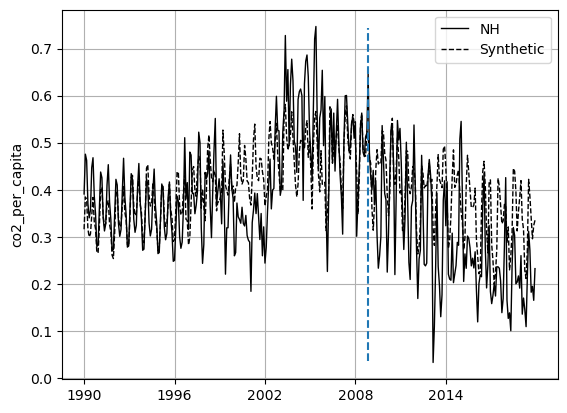

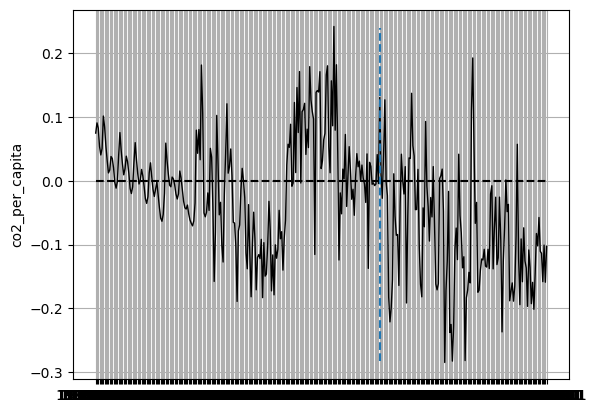

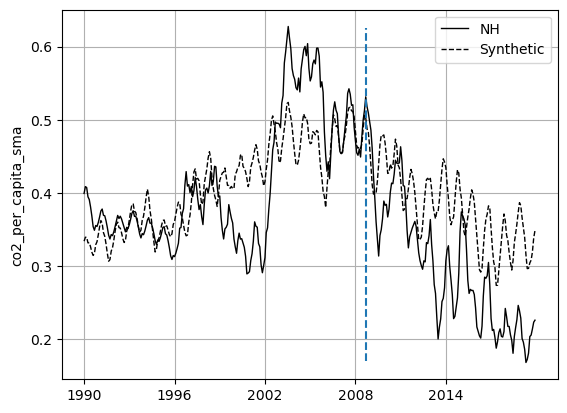

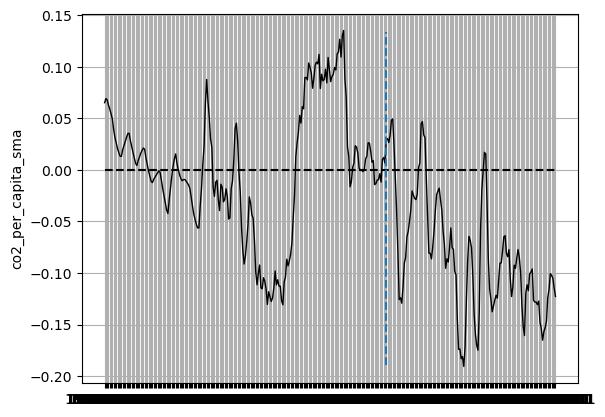

State: NH 

monthly_emissions version: 

IL    0.298
MN    0.237
OR    0.444
SC    0.021
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.060    4.486     18.910       21.661
special.1.eprod_per_capita     0.193    0.008      0.007        0.064
special.2.eflow_per_capita     0.113   -0.011     -0.017        0.031
special.3.gdp_per_capita       0.286    0.004      0.004        0.004
special.4.monthly_pop_density  0.169    0.008      0.019        0.034
special.5.yearly_renew_pct     0.014    0.084      0.346        0.105
special.6.yearly_fossil_pct    0.166    0.359      0.416        0.729
monthly_emissions SMA version: 

IL    0.293
MN    0.257
OR    0.445
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.051    4.486     18.757       21.661
special.1.eprod_per_capita     0.224    0.008      0.007        0.064
special.

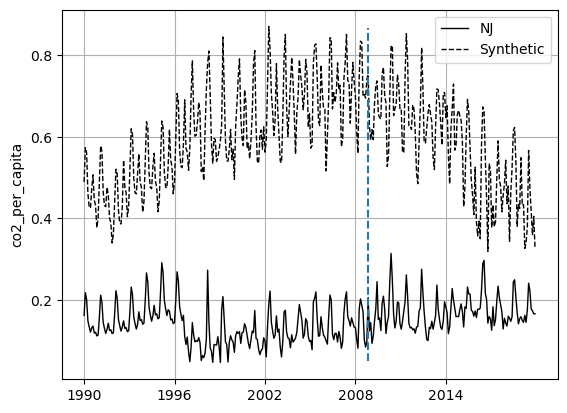

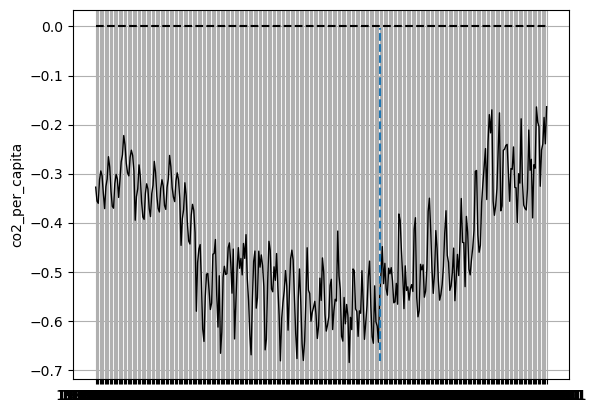

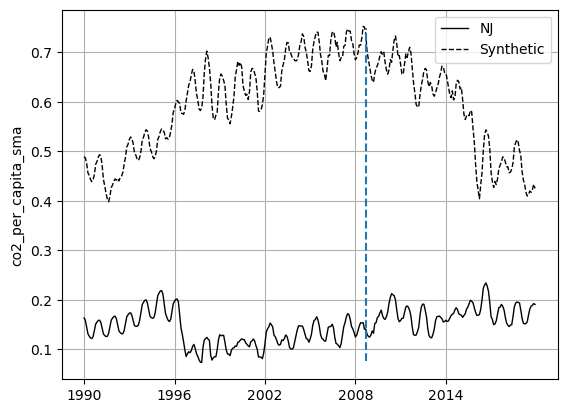

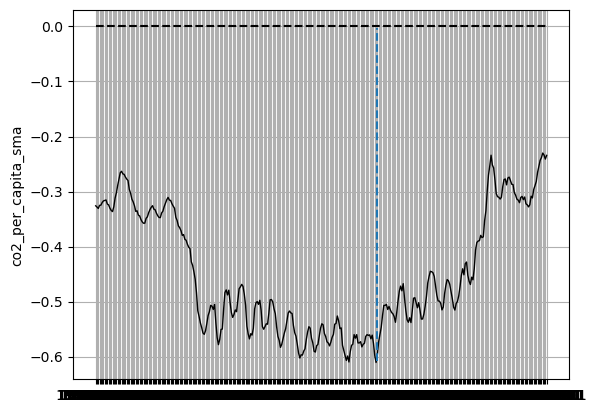

State: NJ 

monthly_emissions version: 

IL    1.0
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.017   31.917     41.028       21.661
special.1.eprod_per_capita     0.143    0.003      0.013        0.064
special.2.eflow_per_capita     0.120   -0.022     -0.013        0.031
special.3.gdp_per_capita       0.047    0.005      0.005        0.004
special.4.monthly_pop_density  0.290    0.001      0.005        0.034
special.5.yearly_renew_pct     0.155    0.000      0.002        0.105
special.6.yearly_fossil_pct    0.227    0.496      0.500        0.729
monthly_emissions SMA version: 

IL    1.0
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.007   31.917     41.028       21.661
special.1.eprod_per_capita     0.188    0.003      0.013        0.064
special.2.eflow_per_capita     0.204   -0.022     -0.013        0.031
sp

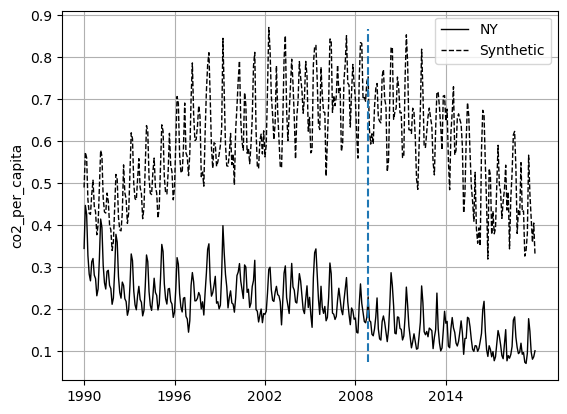

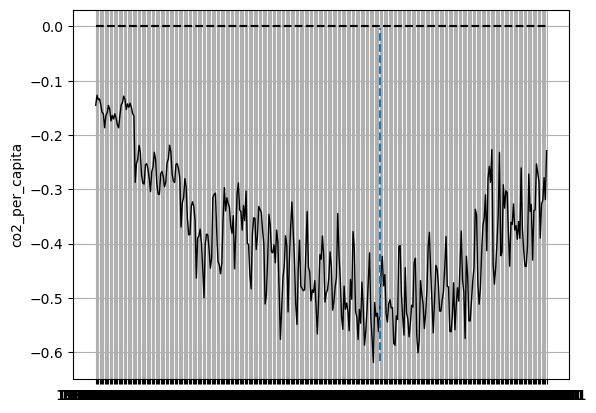

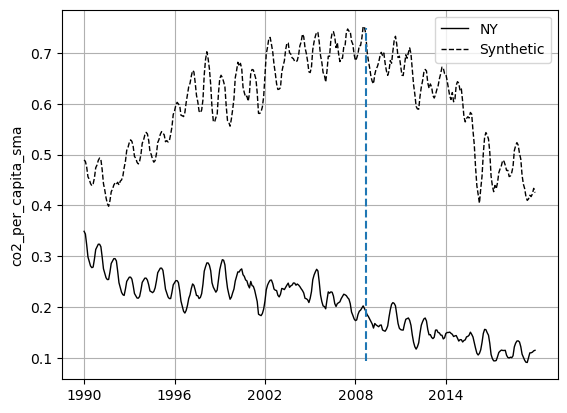

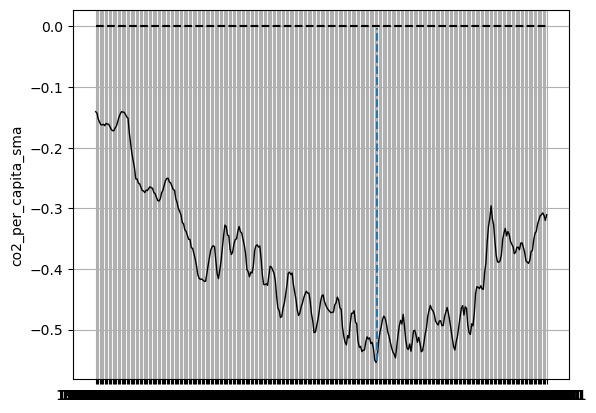

State: NY 

monthly_emissions version: 

IL    1.0
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.054   69.424     41.028       21.661
special.1.eprod_per_capita     0.229    0.003      0.013        0.064
special.2.eflow_per_capita     0.210   -0.014     -0.013        0.031
special.3.gdp_per_capita       0.190    0.005      0.005        0.004
special.4.monthly_pop_density  0.062    0.003      0.005        0.034
special.5.yearly_renew_pct     0.072    0.195      0.002        0.105
special.6.yearly_fossil_pct    0.184    0.540      0.500        0.729
monthly_emissions SMA version: 

IL    1.0
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.058   69.424     41.028       21.661
special.1.eprod_per_capita     0.198    0.003      0.013        0.064
special.2.eflow_per_capita     0.227   -0.014     -0.013        0.031
sp

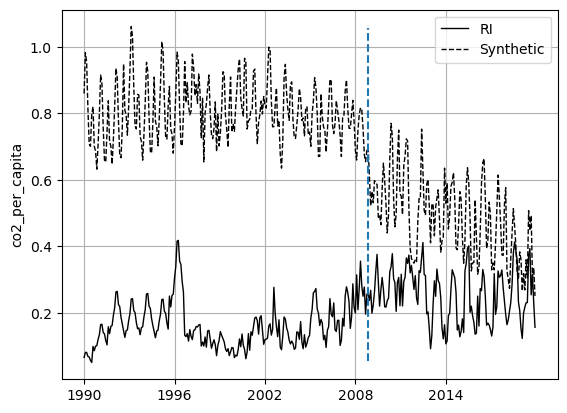

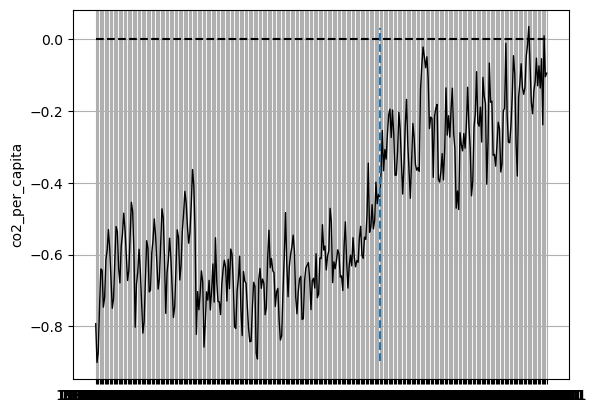

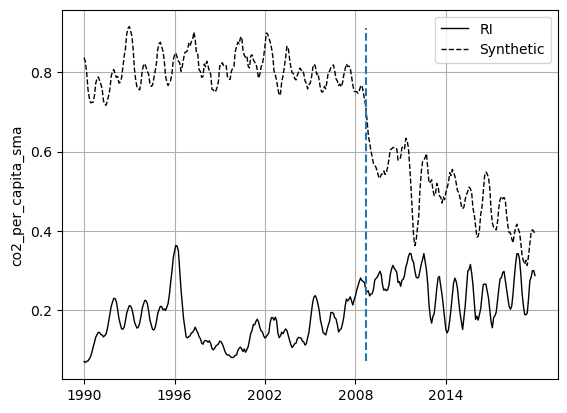

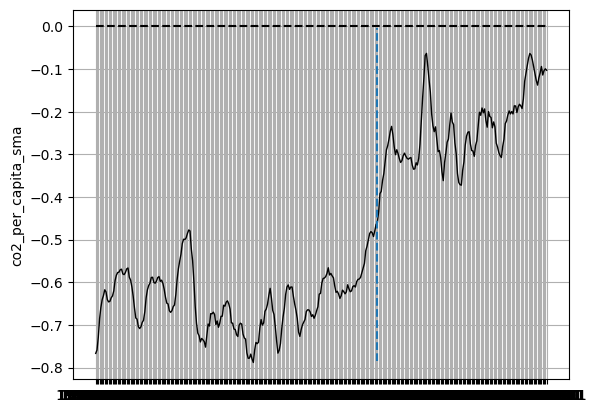

State: RI 

monthly_emissions version: 

MN    0.319
TN    0.681
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.185    4.542     12.718       21.661
special.1.eprod_per_capita     0.172    0.000      0.005        0.064
special.2.eflow_per_capita     0.173   -0.017     -0.024        0.031
special.3.gdp_per_capita       0.189    0.004      0.004        0.004
special.4.monthly_pop_density  0.180    0.001      0.011        0.034
special.5.yearly_renew_pct     0.101    0.001      0.081        0.105
special.6.yearly_fossil_pct    0.000    0.977      0.659        0.729
monthly_emissions SMA version: 

MN    0.316
TN    0.684
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.186    4.542     12.695       21.661
special.1.eprod_per_capita     0.175    0.000      0.005        0.064
special.2.eflow_per_capita     0.183   -0.01

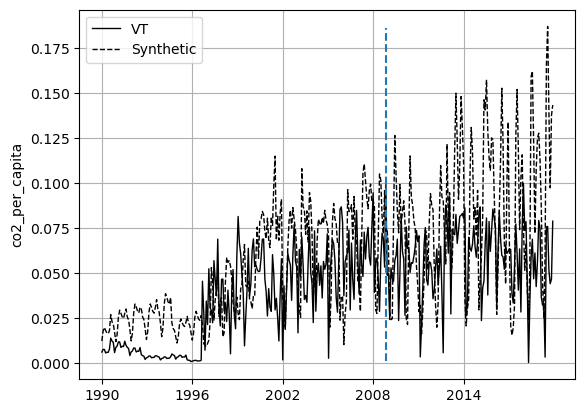

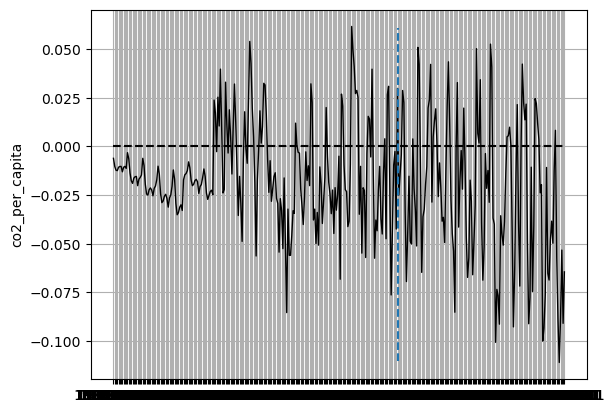

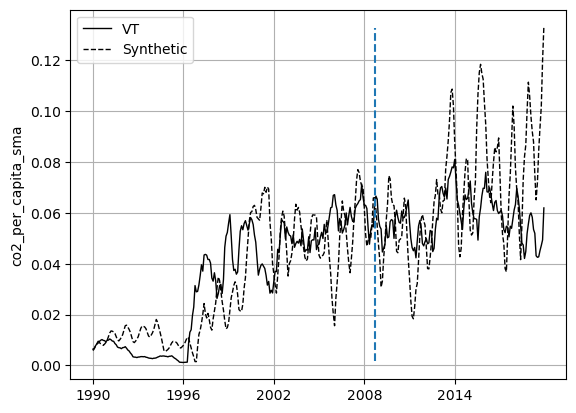

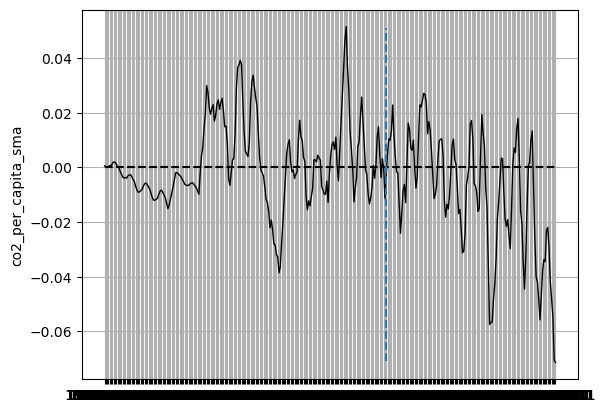

State: VT 

monthly_emissions version: 

ID    0.850
IL    0.017
OR    0.133
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.235    1.000      3.109       21.661
special.1.eprod_per_capita     0.127    0.008      0.004        0.064
special.2.eflow_per_capita     0.345   -0.012     -0.022        0.031
special.3.gdp_per_capita       0.056    0.004      0.003        0.004
special.4.monthly_pop_density  0.006    0.016      0.060        0.034
special.5.yearly_renew_pct     0.004    0.199      0.844        0.105
special.6.yearly_fossil_pct    0.226    0.006      0.099        0.729
monthly_emissions SMA version: 

ID    0.907
OR    0.093
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.212    1.000      2.339       21.661
special.1.eprod_per_capita     0.116    0.008      0.004        0.064
special.2.eflow_per_capita     0

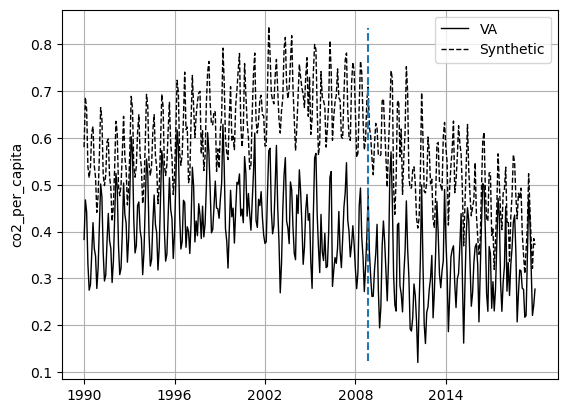

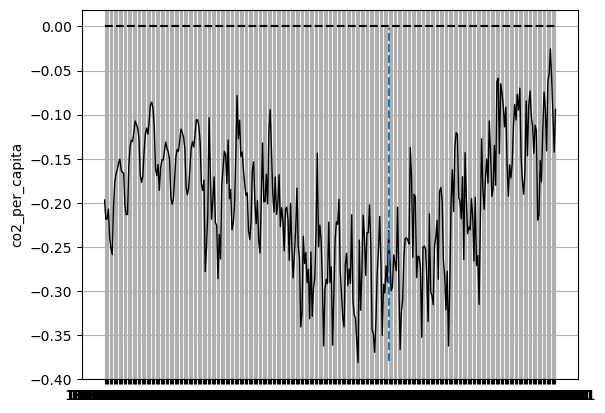

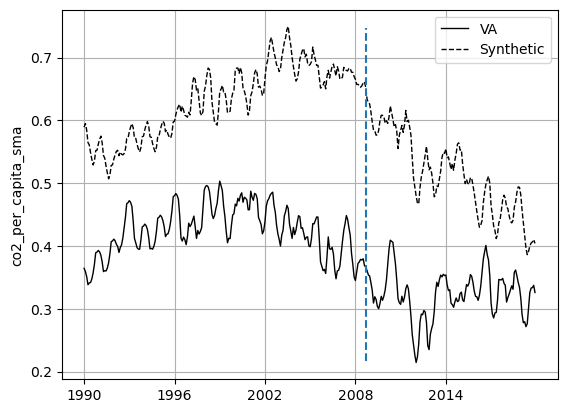

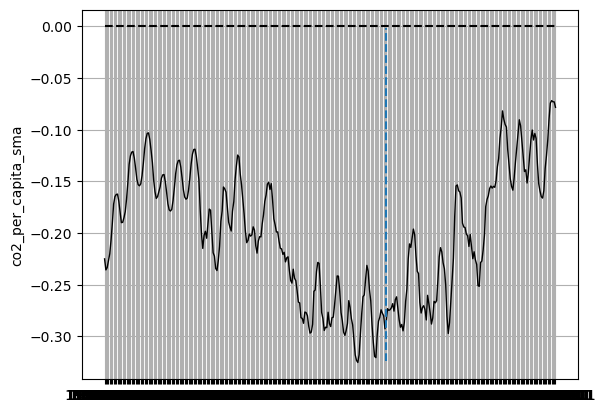

State: VA 

monthly_emissions version: 

IL    0.274
MN    0.654
SC    0.072
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.081   20.986     24.397       21.661
special.1.eprod_per_capita     0.177    0.016      0.007        0.064
special.2.eflow_per_capita     0.136   -0.011     -0.021        0.031
special.3.gdp_per_capita       0.212    0.005      0.004        0.004
special.4.monthly_pop_density  0.142    0.006      0.014        0.034
special.5.yearly_renew_pct     0.170    0.017      0.026        0.105
special.6.yearly_fossil_pct    0.082    0.586      0.610        0.729
monthly_emissions SMA version: 

IL    0.252
MN    0.678
SC    0.070
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.099   20.986     23.888       21.661
special.1.eprod_per_capita     0.152    0.016      0.007        0.064
special.2.eflow_per_

In [628]:
# loop through all RGGI states to see their monthly graphs

for state in rggi_states:

    # monthly_emissions version

    dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['monthly_num_plants'], 
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state,
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

    # month_emissions SMA version

    dataprep_mo_ma = Dataprep(
        foo=df_mo,
        predictors=['monthly_num_plants'],
        predictors_op="mean",
        time_predictors_prior=preintervention_feature_range,
        special_predictors=[
            ('eprod_per_capita', preintervention_energy_range, "mean"),
            ('eflow_per_capita', preintervention_energy_range, "mean"),
            ('gdp_per_capita', preintervention_gdp_range, "mean"),
            ('monthly_pop_density', preintervention_per_capita_range, "mean"),
            ('yearly_renew_pct', preintervention_energy_range, "mean"),
            ('yearly_fossil_pct', preintervention_energy_range, "mean")
            ],
        dependent="co2_per_capita_sma",
        unit_variable="state",
        time_variable="date",
        treatment_identifier=state,
        controls_identifier= non_rggi_controls_identifier,
        time_optimize_ssr=preintervention_ma_range
        )
    
    # monthly_emissions version

    synth_mo = Synth()
    synth_mo.fit(dataprep=dataprep_mo)

    synth_mo.path_plot(time_period=years, treatment_time=treatment_dates[0])
    synth_mo.gaps_plot(time_period=years, treatment_time=treatment_dates[0])
    
    # monthly_emissions SMA version
    
    synth_mo_ma = Synth()
    synth_mo_ma.fit(dataprep=dataprep_mo_ma)

    synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
    synth_mo_ma.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

    print('State:', state,'\n')
    print('monthly_emissions version:','\n')
    print(synth_mo.weights(threshold=.01),'\n')
    print(synth_mo.summary())
    print('monthly_emissions SMA version:','\n')
    print(synth_mo_ma.weights(threshold=.01),'\n')
    print(synth_mo_ma.summary())